# Experience Replay (Memory Object)

- <s, a, r, s' > のセットを記憶
- Memory オブジェクトに格納

 - Double Ended Queue (はみ出すと対端を落とす)

- ミニバッチ（無作為抽出）で学習に投入

In [3]:
import gym
import tensorflow as tf
import numpy as np

In [4]:
env = gym.make('CartPole-v0')

# 多層Qネットワークモデルの実装

- QNetwork クラス

 - コンストラクタにトレーニングまでのモデル実装
 - 入力層：？個→state_size=4個
 - 全結合層1: state_size=4個－（全結合）→hidden_size=10個
 - 全結合層2: hidden_state=10個→hidden_size=10個
 - 出力層:  hidden_state=10個→action_size=2個 : 活性化関数なし
 - 損失関数：2乗和誤差平均
 - 最適化：AdamOptimizer

In [5]:
class QNetwork:
    '''
    Qネットワークを表すクラス
    '''
    
    def __init__(self, learning_rate = 0.01, state_size = 4, action_size = 2, hidden_size = 10, name = 'QNetwork'):
        '''
        DQN実装
        '''
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name = 'inputs')
            self.actions_ = tf.placeholder(tf.int32, [None], name = 'actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            self.targetQs_ = tf.placeholder(tf.float32, [None], name = 'target')
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn = None)
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis = 1) # axisは出力データの次元
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

# エクスペリエンスメモリの実装

- Memory クラス

 - buffer: maxsizeで指定(Double Ended Queue)
 - add: <s,a,r,s'>
 - sample: 無作為抽出
 - 溢れたら古いデータを落とす


In [6]:
from collections import deque
class Memory():
    '''
    エクスペリエンスメモリをあらわすクラス
    '''
    
    def __init__(self, max_size = 1000):
        '''
        max_size:バッファ・サイズ
        '''
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        '''
        バッファの末尾に追加
        '''
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        '''
        batch_size分だけバッファから無作為抽出
        戻り値：buffer_size個の配列、中身は無作為抽出されたバッファ要素
        '''
        
        # idx にはbatch_size個の無作為抽出されたインデックスが入る
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        # 無作為抽出されたインデックスの要素をバッファから取り出し配列にして返却
        return [self.buffer[ii] for ii in idx]

# ハイパーパラメータの定義と初期化

- トレーニング
 -トレーニングする回数
 - 各トレーニング内での試行回数
 - 割引率γ

 - 時々新しい手を探索するためのパラメータ
  - 開始の値
  - 最小の値
  - 減衰する割合

- ネットワークのパラメータ
 - 隠れ層のサイズ
 - 学習率

- メモリ
 - メモリサイズ
 - メモリの中から1回の学習に使うセット（要素）の数
 - 最初にメモリを処理するためのサイズ

In [7]:
# トレーニングする回数
train_episodes = 1000

# 各トレーニング内での試行回数
max_step = 200

# 割引率γ
gannma = 0.9

# 時々新しい手を探索するためのパラメータ
## 開始の値
explore_start = 1.0
## 最小の値
explore_stop = 0.01
## 減衰する割合
decay_rate = 0.0001

# ネットワークのパラメータ
## 隠れ層のサイズ
hidden_size = 64
## 学習率
learning_rate = 0.0001

#メモリ
## メモリサイズ
memory_size = 10000
## メモリの中から1回の学習に使うセット（要素）の数
batch_size = 20
## 最初にメモリを処理するためのサイズ
pretrain_length = batch_size

In [8]:
# 計算グラフの定義

# 一連の式の値を初期化
tf.reset_default_graph()

# Qネットワークを定義
mainQN = QNetwork(name = 'main', hidden_size = hidden_size, learning_rate = learning_rate)

# エクスペリエンスメモリを蓄積

In [9]:
# CartPoleのリセット
env.reset()

# ランダムな手を打つ
state, reward, done, _ = env.step(env.action_space.sample())

# メモリの構築
memory = Memory(max_size = memory_size)

# 学習前最初にメモリを処理するためのループ
for ii in range(pretrain_length):
    # 無作為に手を決める
    action = env.action_space.sample()
    # 手を実行して結果を得る
    next_state, reward, done, _ = env.step(action)
    
    # 倒れたら
    if done:
        # 次の状態は全部ゼロ（なし）
        next_step = np.zeros(state.shape)
        # メモリへ<s, a, r, s' > のセットを格納
        memory.add((state, action, reward, next_state))
        
        # CartPoleをリセット
        env.reset()
        # ランダムな手を打つ
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # メモリへ<s, a, r, s' > のセットを格納
        memory.add((state, action, reward, next_state))
        # 次のループへ向けて状態を更新
        state = next_state

# トレーニング

In [10]:
# モデル保存用オブジェクトを準備
saver = tf.train.Saver()

# 報酬の総和を格納するリスト
rewards_list = []

loss = 0.0

# 計算するセッションを定義
with tf.Session() as sess:
    # 変数を初期化する操作
    sess.run(tf.global_variables_initializer())
    
    # ステップ数カウンタ
    step = 0
    # 試行回数ループ
    for ep in range(1, train_episodes):
        # 報酬合計
        total_rewards = 0
        # 試行内step回数カウンタ
        t = 0
        while t < max_step:
            step += 1
            # ランダムな手を打つ確率を計算
            explore_p = explore_stop + (explore_start - explore_stop * np.exp(-decay_rate * step))
            # 乱数値よりも大きい場合
            if explore_p > np.random.rand():
                # 次の手として無作為にサンプリング取得する
                action = env.action_space.sample()
            else:
                # これまでの良いスコアをもってくる
                feed = {mainQN.inputs_:state.reshape((1, state.shape))}
                # モデルを実行してoutputをもらう
                Qs = sess.run(mainQN.output, feed_dict = feed)
                # 次の手が決まる
                action = np.argmax(Qs)
            
            # 次の手をうち、結果をもらう
            next_state, reward, done, _ = env.step(action)
            # 報酬合計を更新
            total_rewards += reward
            
            # 某が倒れた場合
            if done:
                # 次の手はない
                next_state = np.zeros(state.shape)
                # 試行回数はmax_stepにする
                t = max_step
                
                print('Episode: {}'.format(ep), 'Total Reward: {}'.format(total_rewards), 
                      'Total Loss: {:.4f}'.format(loss), 'Explore Prob: {:.4f}'.format(explore_p))
                # 末尾に今回の試行回数と報酬合計のタプルを追加
                rewards_list.append((ep, total_rewards))
                # メモリへ<s, a, r, s' > のセットを格納
                memory.add((state, action, reward, next_state))
        
                # CartPoleをリセット
                env.reset()
                # ランダムな手を打つ
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                # メモリへ<s, a, r, s' > のセットを格納
                memory.add((state, action, reward, next_state))
                # 次のループへ向けて状態を更新
                state = next_state
                
                # 試行内step回数カウンタ
                t += 1
                
            # バッチデータを取り出して
            batch = memory.sample(batch_size)
            # 配列にセット
            states      = np.array([each[0] for each in batch])
            actions     = np.array([each[1] for each in batch])
            rewards     = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # ターゲットQ値を計算
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_:next_states})
            # エピソードの終わりの値を格納
            episode_ends = (next_states == np.zeros(state[0].shape)).all(axis = 1) # 1番めの要素でソート
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gannma * np.max(target_Qs, axis=1)
            
            # 損失関数を計算
            loss, _ = sess.run([mainQN.loss, mainQN.opt], feed_dict = {
                mainQN.inputs_   : states, 
                mainQN.targetQs_ : targets, 
                mainQN.actions_  : actions})
    # 最後にチェックポイントファイルを保存
    saver.save(sess, "checkpoints/cartpole_dqn.ckpt")

Episode: 1 Total Reward: 5.0 Total Loss: 1.2530 Explore Prob: 1.0000
Episode: 2 Total Reward: 13.0 Total Loss: 1.1328 Explore Prob: 1.0000
Episode: 3 Total Reward: 13.0 Total Loss: 1.1901 Explore Prob: 1.0000
Episode: 4 Total Reward: 20.0 Total Loss: 1.3421 Explore Prob: 1.0001
Episode: 5 Total Reward: 16.0 Total Loss: 1.1807 Explore Prob: 1.0001
Episode: 6 Total Reward: 15.0 Total Loss: 1.2512 Explore Prob: 1.0001
Episode: 7 Total Reward: 11.0 Total Loss: 1.0221 Explore Prob: 1.0001
Episode: 8 Total Reward: 9.0 Total Loss: 1.0553 Explore Prob: 1.0001
Episode: 9 Total Reward: 39.0 Total Loss: 0.8700 Explore Prob: 1.0001
Episode: 10 Total Reward: 16.0 Total Loss: 1.2174 Explore Prob: 1.0002
Episode: 11 Total Reward: 11.0 Total Loss: 1.1148 Explore Prob: 1.0002
Episode: 12 Total Reward: 19.0 Total Loss: 1.0905 Explore Prob: 1.0002
Episode: 13 Total Reward: 35.0 Total Loss: 1.0783 Explore Prob: 1.0002
Episode: 14 Total Reward: 18.0 Total Loss: 1.0405 Explore Prob: 1.0002
Episode: 15 Total

Episode: 117 Total Reward: 20.0 Total Loss: 3.4738 Explore Prob: 1.0020
Episode: 118 Total Reward: 80.0 Total Loss: 13.8955 Explore Prob: 1.0021
Episode: 119 Total Reward: 14.0 Total Loss: 4.9345 Explore Prob: 1.0021
Episode: 120 Total Reward: 9.0 Total Loss: 10.1043 Explore Prob: 1.0021
Episode: 121 Total Reward: 15.0 Total Loss: 6.3664 Explore Prob: 1.0021
Episode: 122 Total Reward: 37.0 Total Loss: 0.3490 Explore Prob: 1.0021
Episode: 123 Total Reward: 14.0 Total Loss: 16.6208 Explore Prob: 1.0022
Episode: 124 Total Reward: 21.0 Total Loss: 6.3547 Explore Prob: 1.0022
Episode: 125 Total Reward: 13.0 Total Loss: 14.7049 Explore Prob: 1.0022
Episode: 126 Total Reward: 21.0 Total Loss: 0.3859 Explore Prob: 1.0022
Episode: 127 Total Reward: 15.0 Total Loss: 13.1685 Explore Prob: 1.0022
Episode: 128 Total Reward: 15.0 Total Loss: 18.4838 Explore Prob: 1.0022
Episode: 129 Total Reward: 28.0 Total Loss: 11.1385 Explore Prob: 1.0022
Episode: 130 Total Reward: 67.0 Total Loss: 0.3109 Explore

Episode: 232 Total Reward: 32.0 Total Loss: 3.3019 Explore Prob: 1.0037
Episode: 233 Total Reward: 30.0 Total Loss: 0.1192 Explore Prob: 1.0038
Episode: 234 Total Reward: 9.0 Total Loss: 0.1343 Explore Prob: 1.0038
Episode: 235 Total Reward: 17.0 Total Loss: 1.2932 Explore Prob: 1.0038
Episode: 236 Total Reward: 8.0 Total Loss: 1.5556 Explore Prob: 1.0038
Episode: 237 Total Reward: 18.0 Total Loss: 2.7989 Explore Prob: 1.0038
Episode: 238 Total Reward: 35.0 Total Loss: 1.5686 Explore Prob: 1.0038
Episode: 239 Total Reward: 47.0 Total Loss: 0.1710 Explore Prob: 1.0038
Episode: 240 Total Reward: 34.0 Total Loss: 0.1236 Explore Prob: 1.0039
Episode: 241 Total Reward: 12.0 Total Loss: 1.7291 Explore Prob: 1.0039
Episode: 242 Total Reward: 18.0 Total Loss: 3.1041 Explore Prob: 1.0039
Episode: 243 Total Reward: 17.0 Total Loss: 0.0869 Explore Prob: 1.0039
Episode: 244 Total Reward: 14.0 Total Loss: 1.7581 Explore Prob: 1.0039
Episode: 245 Total Reward: 21.0 Total Loss: 2.8993 Explore Prob: 1

Episode: 350 Total Reward: 42.0 Total Loss: 1.0366 Explore Prob: 1.0052
Episode: 351 Total Reward: 25.0 Total Loss: 0.2697 Explore Prob: 1.0052
Episode: 352 Total Reward: 15.0 Total Loss: 2.3082 Explore Prob: 1.0052
Episode: 353 Total Reward: 23.0 Total Loss: 0.1442 Explore Prob: 1.0052
Episode: 354 Total Reward: 17.0 Total Loss: 1.5670 Explore Prob: 1.0052
Episode: 355 Total Reward: 39.0 Total Loss: 5.1856 Explore Prob: 1.0052
Episode: 356 Total Reward: 15.0 Total Loss: 1.2493 Explore Prob: 1.0052
Episode: 357 Total Reward: 33.0 Total Loss: 0.1765 Explore Prob: 1.0053
Episode: 358 Total Reward: 14.0 Total Loss: 1.1418 Explore Prob: 1.0053
Episode: 359 Total Reward: 14.0 Total Loss: 1.2330 Explore Prob: 1.0053
Episode: 360 Total Reward: 22.0 Total Loss: 0.7416 Explore Prob: 1.0053
Episode: 361 Total Reward: 13.0 Total Loss: 0.1834 Explore Prob: 1.0053
Episode: 362 Total Reward: 20.0 Total Loss: 0.1899 Explore Prob: 1.0053
Episode: 363 Total Reward: 8.0 Total Loss: 3.8713 Explore Prob: 

Episode: 465 Total Reward: 10.0 Total Loss: 3.6719 Explore Prob: 1.0062
Episode: 466 Total Reward: 24.0 Total Loss: 0.1470 Explore Prob: 1.0063
Episode: 467 Total Reward: 34.0 Total Loss: 2.8591 Explore Prob: 1.0063
Episode: 468 Total Reward: 12.0 Total Loss: 1.5109 Explore Prob: 1.0063
Episode: 469 Total Reward: 35.0 Total Loss: 0.7798 Explore Prob: 1.0063
Episode: 470 Total Reward: 13.0 Total Loss: 0.4125 Explore Prob: 1.0063
Episode: 471 Total Reward: 16.0 Total Loss: 0.9305 Explore Prob: 1.0063
Episode: 472 Total Reward: 16.0 Total Loss: 1.9163 Explore Prob: 1.0063
Episode: 473 Total Reward: 16.0 Total Loss: 0.2134 Explore Prob: 1.0063
Episode: 474 Total Reward: 22.0 Total Loss: 1.4772 Explore Prob: 1.0063
Episode: 475 Total Reward: 39.0 Total Loss: 3.6739 Explore Prob: 1.0063
Episode: 476 Total Reward: 52.0 Total Loss: 2.6946 Explore Prob: 1.0063
Episode: 477 Total Reward: 20.0 Total Loss: 2.8903 Explore Prob: 1.0064
Episode: 478 Total Reward: 35.0 Total Loss: 1.0155 Explore Prob:

Episode: 583 Total Reward: 12.0 Total Loss: 0.1958 Explore Prob: 1.0071
Episode: 584 Total Reward: 12.0 Total Loss: 0.1677 Explore Prob: 1.0071
Episode: 585 Total Reward: 9.0 Total Loss: 0.2070 Explore Prob: 1.0071
Episode: 586 Total Reward: 18.0 Total Loss: 0.1785 Explore Prob: 1.0071
Episode: 587 Total Reward: 17.0 Total Loss: 2.0664 Explore Prob: 1.0071
Episode: 588 Total Reward: 46.0 Total Loss: 3.1253 Explore Prob: 1.0071
Episode: 589 Total Reward: 41.0 Total Loss: 3.0525 Explore Prob: 1.0071
Episode: 590 Total Reward: 21.0 Total Loss: 0.1623 Explore Prob: 1.0071
Episode: 591 Total Reward: 28.0 Total Loss: 0.1582 Explore Prob: 1.0072
Episode: 592 Total Reward: 43.0 Total Loss: 2.4835 Explore Prob: 1.0072
Episode: 593 Total Reward: 20.0 Total Loss: 0.1402 Explore Prob: 1.0072
Episode: 594 Total Reward: 25.0 Total Loss: 0.8844 Explore Prob: 1.0072
Episode: 595 Total Reward: 23.0 Total Loss: 0.2525 Explore Prob: 1.0072
Episode: 596 Total Reward: 12.0 Total Loss: 0.6592 Explore Prob: 

Episode: 702 Total Reward: 26.0 Total Loss: 0.1555 Explore Prob: 1.0078
Episode: 703 Total Reward: 14.0 Total Loss: 2.3611 Explore Prob: 1.0078
Episode: 704 Total Reward: 12.0 Total Loss: 1.9850 Explore Prob: 1.0078
Episode: 705 Total Reward: 13.0 Total Loss: 0.6142 Explore Prob: 1.0078
Episode: 706 Total Reward: 9.0 Total Loss: 0.4371 Explore Prob: 1.0078
Episode: 707 Total Reward: 14.0 Total Loss: 0.8870 Explore Prob: 1.0078
Episode: 708 Total Reward: 19.0 Total Loss: 0.7044 Explore Prob: 1.0078
Episode: 709 Total Reward: 27.0 Total Loss: 1.3989 Explore Prob: 1.0078
Episode: 710 Total Reward: 46.0 Total Loss: 0.2612 Explore Prob: 1.0078
Episode: 711 Total Reward: 12.0 Total Loss: 0.0771 Explore Prob: 1.0078
Episode: 712 Total Reward: 34.0 Total Loss: 0.3043 Explore Prob: 1.0078
Episode: 713 Total Reward: 8.0 Total Loss: 0.1364 Explore Prob: 1.0078
Episode: 714 Total Reward: 32.0 Total Loss: 1.2959 Explore Prob: 1.0078
Episode: 715 Total Reward: 13.0 Total Loss: 0.1664 Explore Prob: 1

Episode: 820 Total Reward: 19.0 Total Loss: 4.2594 Explore Prob: 1.0082
Episode: 821 Total Reward: 9.0 Total Loss: 0.3830 Explore Prob: 1.0082
Episode: 822 Total Reward: 31.0 Total Loss: 0.1486 Explore Prob: 1.0082
Episode: 823 Total Reward: 16.0 Total Loss: 0.9696 Explore Prob: 1.0082
Episode: 824 Total Reward: 13.0 Total Loss: 0.0583 Explore Prob: 1.0082
Episode: 825 Total Reward: 62.0 Total Loss: 0.0901 Explore Prob: 1.0082
Episode: 826 Total Reward: 21.0 Total Loss: 0.1105 Explore Prob: 1.0082
Episode: 827 Total Reward: 14.0 Total Loss: 0.0977 Explore Prob: 1.0082
Episode: 828 Total Reward: 16.0 Total Loss: 0.1221 Explore Prob: 1.0083
Episode: 829 Total Reward: 15.0 Total Loss: 1.7674 Explore Prob: 1.0083
Episode: 830 Total Reward: 15.0 Total Loss: 0.4993 Explore Prob: 1.0083
Episode: 831 Total Reward: 14.0 Total Loss: 0.3963 Explore Prob: 1.0083
Episode: 832 Total Reward: 14.0 Total Loss: 2.2631 Explore Prob: 1.0083
Episode: 833 Total Reward: 17.0 Total Loss: 0.1678 Explore Prob: 

Episode: 935 Total Reward: 14.0 Total Loss: 0.0778 Explore Prob: 1.0086
Episode: 936 Total Reward: 37.0 Total Loss: 1.6718 Explore Prob: 1.0086
Episode: 937 Total Reward: 24.0 Total Loss: 4.8626 Explore Prob: 1.0086
Episode: 938 Total Reward: 23.0 Total Loss: 0.6064 Explore Prob: 1.0086
Episode: 939 Total Reward: 38.0 Total Loss: 0.1695 Explore Prob: 1.0086
Episode: 940 Total Reward: 17.0 Total Loss: 0.3537 Explore Prob: 1.0086
Episode: 941 Total Reward: 21.0 Total Loss: 0.9178 Explore Prob: 1.0086
Episode: 942 Total Reward: 16.0 Total Loss: 0.0675 Explore Prob: 1.0086
Episode: 943 Total Reward: 7.0 Total Loss: 0.4096 Explore Prob: 1.0086
Episode: 944 Total Reward: 20.0 Total Loss: 1.3643 Explore Prob: 1.0086
Episode: 945 Total Reward: 18.0 Total Loss: 1.1258 Explore Prob: 1.0086
Episode: 946 Total Reward: 34.0 Total Loss: 0.1588 Explore Prob: 1.0086
Episode: 947 Total Reward: 23.0 Total Loss: 0.0929 Explore Prob: 1.0086
Episode: 948 Total Reward: 23.0 Total Loss: 0.1399 Explore Prob: 

# トレーニング結果の可視化

In [11]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    '''
    移動平均を計算する関数
    '''
    cumsum = np.cumsum(np.insert(x,0,0))
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Rewards')

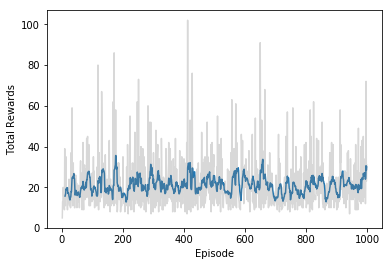

In [12]:
# [(エピソード番号, 報酬和),(エピソード番号, 報酬和),.. (エピソード番号, 報酬和)] から
# [(エピソード番号, エピソード番号,.. , エピソード番号), (報酬和, 報酬和,.. ,報酬和)] に変換
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews,10)
plt.plot(eps[-len(smoothed_rews):],smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Rewards')

# テスト

In [13]:
# テスト試行回数
test_episodes = 10
# 試行1回中何回左右に動かすか
test_max_steps = 400

# ゲームのリセット
env.reset()

# モデル保存用オブジェクトを準備
#saver = tf.train.Saver()

# 
with tf.Session() as sess:
    # チェックポイントから復元
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # テスト試行ループ
    for ep in range(1, test_episodes):
        # 試行内ステップカウンタ
        t = 0
        # 試行内ステップループ
        while t< test_max_steps:
            # ゲームを表示
            env.render()
            
            # モデル十実行
            feed = {mainQN.inputs_:state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            # 指し手を決める
            action = np.argmax(Qs)
            
            # 指し手を実行し、結果を取得
            next_state, reward, done, _ = env.step(action)
            
            # 棒が倒れたら
            if done:
                # カウンタを最大に
                t = test_max_steps
                # ゲームをリセット
                env.reset()
                # 最初の手はランダムで取得
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                # 次のステップへの準備
                state = next_state
                # ステップカウンタ加算
                t += 1
                

INFO:tensorflow:Restoring parameters from checkpoints\cartpole_dqn.ckpt
